# Demo

In [2]:
import numpy as np
from lucifex.fdm import AB, CN
from lucifex.sim import run, xdmf_to_npz
from lucifex.viz import plot_colormap, create_animation, plot_line, save_figure, display_animation
from crocodil.dns.system_a import dns_system_a

STORE = 1
WRITE = None
DIR_BASE = './data'
DIR_PARAMS = ('Ra', 'Da', 'epsilon', 'sr', 'cr', 'Nx', 'Ny')

sr = 0.2
simulation = dns_system_a(
    store_delta=STORE, 
    write_delta=WRITE, 
    dir_base=DIR_BASE, 
    dir_params=DIR_PARAMS,
)(
    aspect=2.0,
    Nx=64,
    Ny=64,
    scaling='advective',
    Ra=5e2,
    Da=100.0,
    epsilon=1e-2,
    sr=sr,
    cr=0.0,
    D_adv=AB(2)@CN, 
    D_diff=AB(1)@CN,
    dt_max=0.1,
    cfl_courant=0.25,
    # s_limits=(0, sr),
    c_limits=(0, 1),
    c_stabilization=None,
    diagnostic=True,
)

t_stop = 12.0
n_stop = 300
dt_init = 1e-6
n_init = 10
run(simulation, t_stop=t_stop, n_stop=n_stop, dt_init=dt_init, n_init=n_init)
if WRITE:
    xdmf_to_npz(simulation, delete_xdmf=False)

s, c, u, psi = simulation['s', 'c', 'u', 'psi']

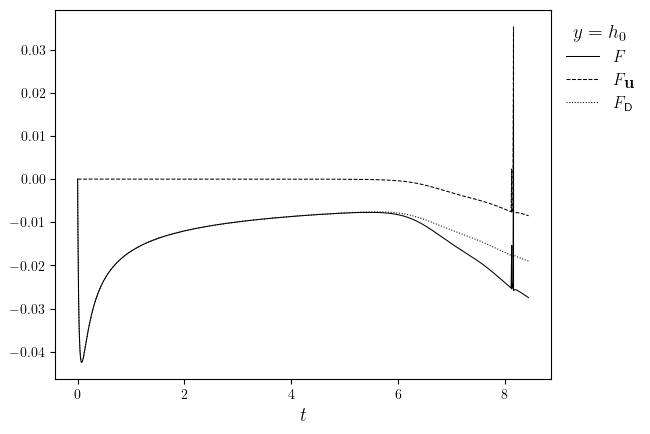

In [3]:
f = simulation['f']
f, fPlus, fMinus = f.split()

fig, ax = plot_line(
    [(f.time_series, [np.sum(i) for i in f.value_series]), (f.time_series, f.value_series)],
    cyc='black',
    x_label='$t$',
    legend_labels=['$F$', '$F_{\\textbf{u}}$', '$F_{\mathsf{D}}$'],
    legend_title='$y=h_0$',
)
save_figure('f(y=h0,t)', simulation.dir_path, prefix_ipynb=False)(fig)

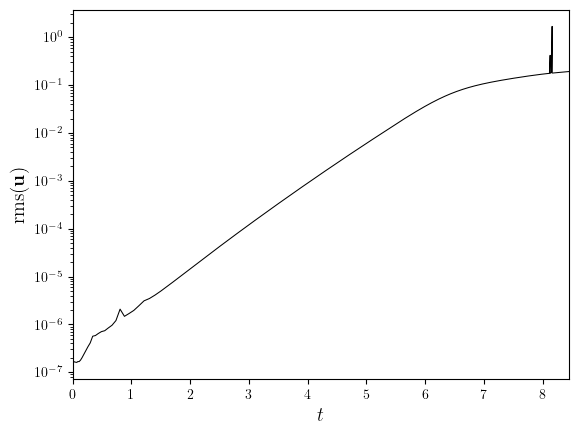

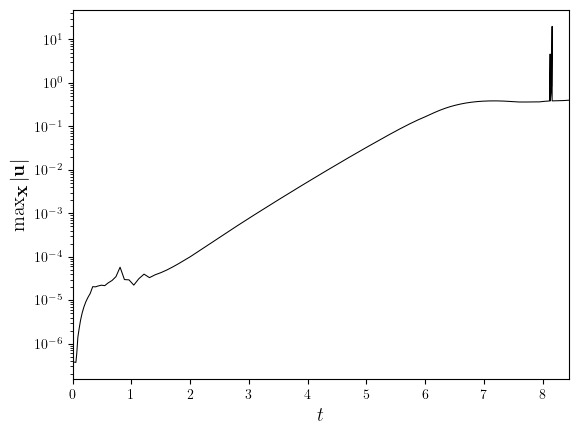

In [4]:
uRMS, uMinMax = simulation['uRMS', 'uMinMax']
uMax = uMinMax.sub(1)

fig, ax = plot_line(
    (uRMS.time_series, uRMS.value_series),
    x_label='$t$',
    y_label='$\mathrm{rms}(\\textbf{u})$',
)
ax.set_yscale('log')
save_figure('uRMS(t)', simulation.dir_path, prefix_ipynb=False)(fig)

fig, ax = plot_line(
    (uMax.time_series, uMax.value_series),
    x_label='$t$',
    y_label='$\max_{\\textbf{x}}|\\textbf{u}|$',
)
ax.set_yscale('log')
save_figure('uMax(t)', simulation.dir_path)(fig)

In [ ]:
time_slice = slice(0, None, 2)
titles = [f'${c.name}(t={t:.3f})$' for t in c.time_series[time_slice]]

anim = create_animation(
    plot_colormap,
    colorbar=False,
)(c.series[time_slice], title=titles)
anim_path = save_figure(f'{c.name}(t)', simulation.dir_path, get_path=True)(anim)

display_animation(anim_path)

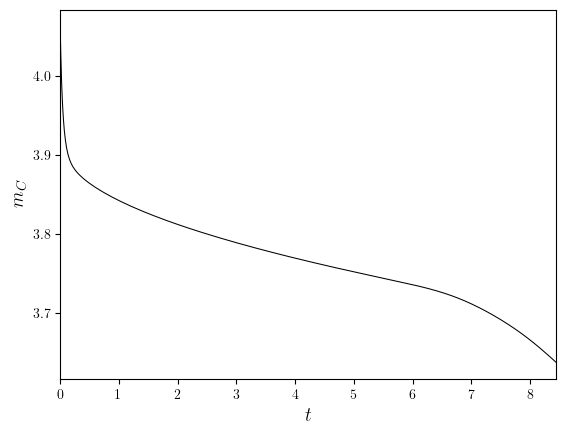

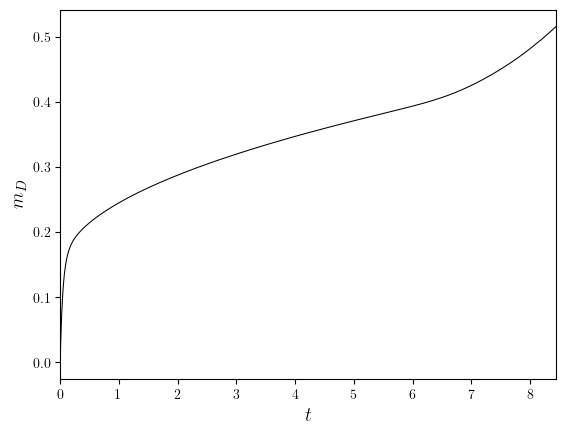

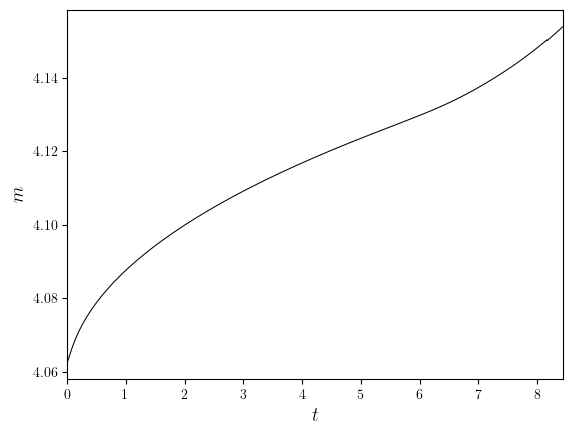

In [5]:
mC, mD = simulation['mC', 'mD']

fig, ax = plot_line(
    (mC.time_series, mC.value_series),
    x_label='$t$',
    y_label='$m_C$',
)
save_figure('mC(t)', simulation.dir_path)(fig)

fig, ax = plot_line(
    (mD.time_series, mD.value_series),
    x_label='$t$',
    y_label='$m_D$'
)
save_figure('mD(t)', simulation.dir_path)(fig)

fig, ax = plot_line(
    (mC.time_series, [i + j for i, j in zip(mC.value_series, mD.value_series)]),
    x_label='$t$',
    y_label='$m$'
)
save_figure('m(t)', simulation.dir_path)(fig)

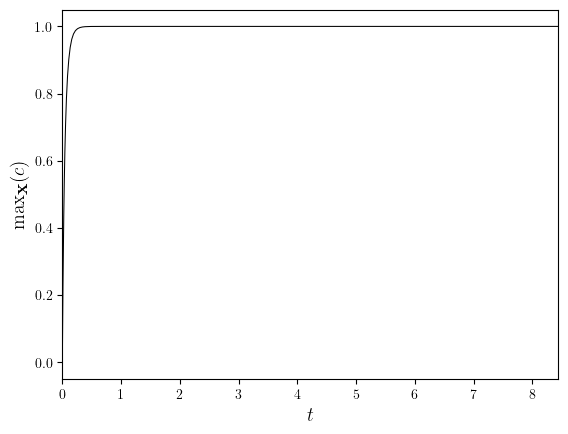

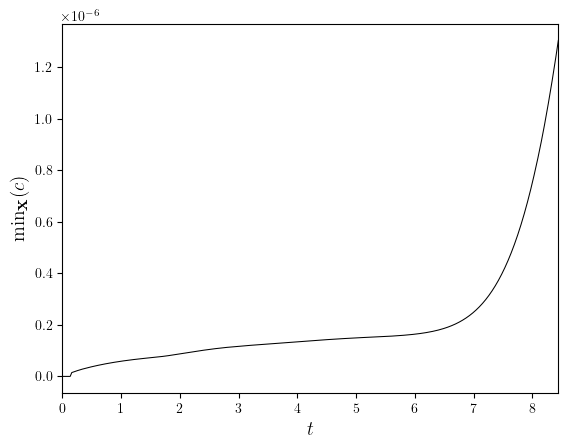

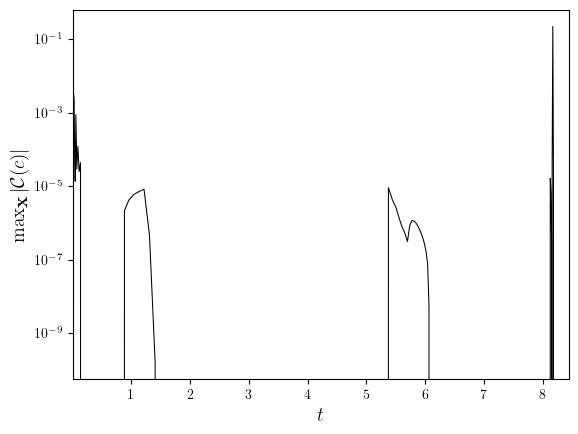

In [6]:
cMinMax, cCorr = simulation['cMinMax', 'cCorr']
cMin, cMax = cMinMax.split()

fig, ax = plot_line(
    (cMax.time_series, cMax.value_series),
    x_label='$t$',
    y_label='$\max_{\\textbf{x}}(c)$',
)
save_figure('cMax(t)', simulation.dir_path)(fig)

fig, ax = plot_line(
    (cMin.time_series, cMin.value_series),
    x_label='$t$',
    y_label='$\min_{\\textbf{x}}(c)$',
)
save_figure('cMin(t)', simulation.dir_path)(fig)

fig, ax = plot_line(
    (cCorr.time_series, [np.max(np.abs(i)) for i in cCorr.dofs_series]),
    x_label='$t$',
    y_label='$\max_{\\textbf{x}}|\mathcal{C}(c)|$',
)
ax.set_yscale('log')
save_figure('cCorrMax(t)', simulation.dir_path)(fig)

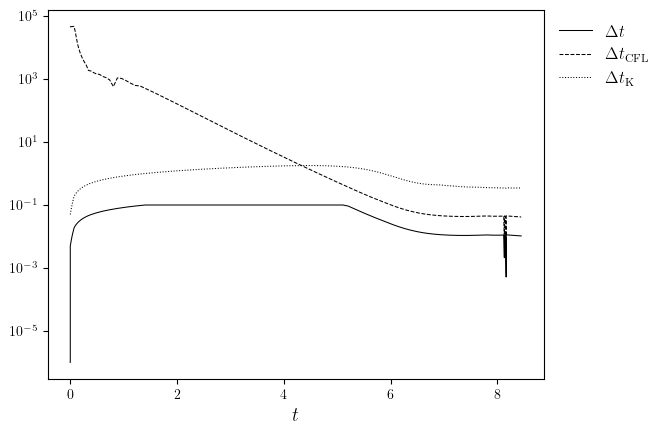

In [7]:
dt, dtCFL, dtK = simulation['dt', 'dtCFL', 'dtK']

fig, ax = plot_line(
    [(dt.time_series, dt.value_series), (dtCFL.time_series, dtCFL.value_series), (dtK.time_series, dtK.value_series)],
    x_label='$t$',
    legend_labels=['$\Delta t$', '$\Delta t_{\mathrm{CFL}}$', '$\Delta t_{\mathrm{K}}$'],
)
ax.set_yscale('log')
save_figure('dt(t)', simulation.dir_path, prefix_ipynb=False)(fig)